In [30]:
import os
import torch
import matplotlib.pyplot as plt
from collections import defaultdict
from lightglue import LightGlue, SuperPoint
from lightglue.utils import load_image, rbd


def extract_features(image_paths, extractor):
    features = {}
    for path in image_paths:
        image = load_image(path).cuda()
        feats = extractor.extract(image)
        features[path] = feats
    return features


def match_pair(feats0, feats1, matcher):
    matches01 = matcher({"image0": feats0, "image1": feats1})
    feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]]
    matches = matches01["matches"]
    if matches.numel() == 0:
        return [], [], 0
    points0 = feats0["keypoints"][matches[:, 0]]
    points1 = feats1["keypoints"][matches[:, 1]]
    return points0.cpu().numpy(), points1.cpu().numpy(), matches.shape[0]


def build_incremental_graph_iterative(image_paths, features, matcher, min_matches=100):
    graph = defaultdict(list)
    added_nodes = set()
    remaining = set(image_paths)

    # Initialisation avec la première image
    start = image_paths[0]
    added_nodes.add(start)
    remaining.remove(start)

    iteration = 0
    while True:
        iteration += 1
        newly_added = set()
        print(f"\n🔁 Iteration {iteration} - Images restantes : {len(remaining)}")

        for img in list(remaining):
            for existing_img in added_nodes:
                _, _, num_matches = match_pair(features[img], features[existing_img], matcher)
                if num_matches >= min_matches:
                    graph[img].append(existing_img)
                    graph[existing_img].append(img)
                    newly_added.add(img)
                    print(f"✅ Ajout: {os.path.basename(img)} <-> {os.path.basename(existing_img)} ({num_matches} matches)")
                    break
            else:
                print(f"❌ Aucun match suffisant pour {os.path.basename(img)}")

        if not newly_added:
            break  # aucune nouvelle image ajoutée → fin

        added_nodes.update(newly_added)
        remaining -= newly_added

    return graph, remaining


# === MAIN ===
image_dir = "/home/jourdelune/Images/colmap/input"
image_paths = sorted(              
    [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
)

# Initialisation
extractor = SuperPoint(max_num_keypoints=2048).eval().cuda()
matcher = LightGlue(features="superpoint").eval().cuda()

# 🔍 Extraction des features
features = extract_features(image_paths, extractor)

# 🔁 Construction du graphe itérative
graph, unmatched_images = build_incremental_graph_iterative(image_paths, features, matcher, min_matches=100)

# 🧾 Affichage
print("\n📊 Graphe final :")
for node, neighbors in graph.items():
    print(f"{os.path.basename(node)} --> {[os.path.basename(n) for n in neighbors]}")

print(f"\n📉 Images connectées : {len(graph)} / {len(image_paths)}")
print(f"📁 Images non connectées : {len(unmatched_images)}")



🔁 Iteration 1 - Images restantes : 25
❌ Aucun match suffisant pour image23.jpg
❌ Aucun match suffisant pour image24.jpg
✅ Ajout: image17.jpg <-> image1.jpg (230 matches)
✅ Ajout: image25.jpg <-> image1.jpg (128 matches)
❌ Aucun match suffisant pour image20.jpg
✅ Ajout: image5.jpg <-> image1.jpg (204 matches)
❌ Aucun match suffisant pour image9.jpg
❌ Aucun match suffisant pour image14.jpg
❌ Aucun match suffisant pour image11.jpg
✅ Ajout: image27.jpg <-> image1.jpg (125 matches)
❌ Aucun match suffisant pour image4.jpg
✅ Ajout: image8.jpg <-> image1.jpg (185 matches)
✅ Ajout: image7.jpg <-> image1.jpg (715 matches)
✅ Ajout: image16.jpg <-> image1.jpg (133 matches)
❌ Aucun match suffisant pour image22.jpg
✅ Ajout: image15.jpg <-> image1.jpg (635 matches)
❌ Aucun match suffisant pour image6.jpg
❌ Aucun match suffisant pour image18.jpg
✅ Ajout: image12.jpg <-> image1.jpg (444 matches)
❌ Aucun match suffisant pour image26.jpg
❌ Aucun match suffisant pour image13.jpg
❌ Aucun match suffisant p

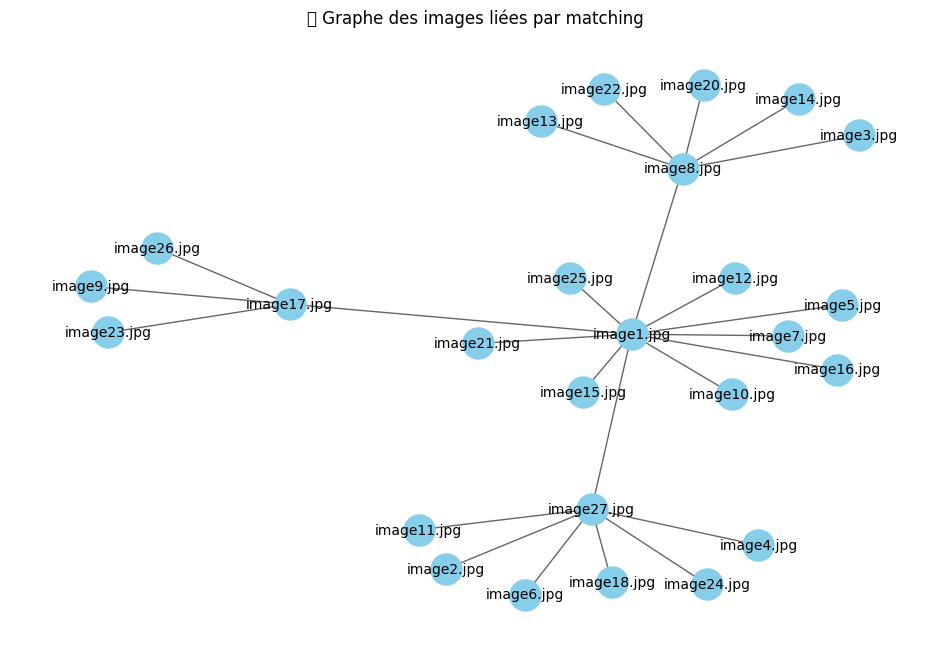

In [39]:
import networkx as nx

def visualize_graph(graph):
    G = nx.Graph()

    # Ajout des sommets et des arêtes
    for node, neighbors in graph.items():
        node_name = os.path.basename(node)
        G.add_node(node_name)
        for neighbor in neighbors:
            neighbor_name = os.path.basename(neighbor)
            G.add_edge(node_name, neighbor_name)

    # Position automatique
    pos = nx.spring_layout(G, seed=42)

    # Affichage 
    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=500)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.6)
    nx.draw_networkx_labels(G, pos, font_size=10)
    plt.title("🔗 Graphe des images liées par matching")
    plt.axis('off')
    plt.show()

# Appel
visualize_graph(graph)


Ensuite avec le graph, généré des batchs qui doivent respecter les contraintes suivantes :
- Les images présente dans le batch doivent tous être reliable à partir d'une branche dans le batch, chaque batch doit être un graphe non disjoint.
- Toujours faire en sorte que chaque batch contienne n image ou moins, mais faire en sorte que le batch soit aussi grand que possible (mais pas plus grand que n).

Ensuite avec le graph, généré des batchs qui doivent respecter les contraintes suivantes :
- Les images présente dans le batch doivent tous être reliable à partir d'une branche dans le batch, chaque batch doit donc être un graphe non disjoint.
- Toujours faire en sorte que chaque batch contienne n image ou moins, mais faire en sorte que le batch soit aussi grand que possible (mais pas plus grand que n).
Une fois le script généré, affiche de nouveau le garphe avec une couleur différente pour chaque batch, tu testera avec un batch de 4

In [40]:
print(graph)

defaultdict(<class 'list'>, {'/home/jourdelune/Images/colmap/input/image17.jpg': ['/home/jourdelune/Images/colmap/input/image1.jpg', '/home/jourdelune/Images/colmap/input/image23.jpg', '/home/jourdelune/Images/colmap/input/image9.jpg', '/home/jourdelune/Images/colmap/input/image26.jpg'], '/home/jourdelune/Images/colmap/input/image1.jpg': ['/home/jourdelune/Images/colmap/input/image17.jpg', '/home/jourdelune/Images/colmap/input/image25.jpg', '/home/jourdelune/Images/colmap/input/image5.jpg', '/home/jourdelune/Images/colmap/input/image27.jpg', '/home/jourdelune/Images/colmap/input/image8.jpg', '/home/jourdelune/Images/colmap/input/image7.jpg', '/home/jourdelune/Images/colmap/input/image16.jpg', '/home/jourdelune/Images/colmap/input/image15.jpg', '/home/jourdelune/Images/colmap/input/image12.jpg', '/home/jourdelune/Images/colmap/input/image21.jpg', '/home/jourdelune/Images/colmap/input/image10.jpg'], '/home/jourdelune/Images/colmap/input/image25.jpg': ['/home/jourdelune/Images/colmap/inpu

In [42]:
def convert_to_binary_tree(graph, root):
    binary_tree = defaultdict(list)
    visited = set()

    def dfs(current):
        visited.add(current)
        children = [n for n in graph[current] if n not in visited]

        if not children:
            return

        leftmost = children[0]
        binary_tree[current].append(leftmost)
        dfs(leftmost)

        # Siblings become right child chain
        prev = leftmost
        for sibling in children[1:]:
            binary_tree[prev].append(sibling)
            dfs(sibling)
            prev = sibling

    dfs(root)
    return binary_tree


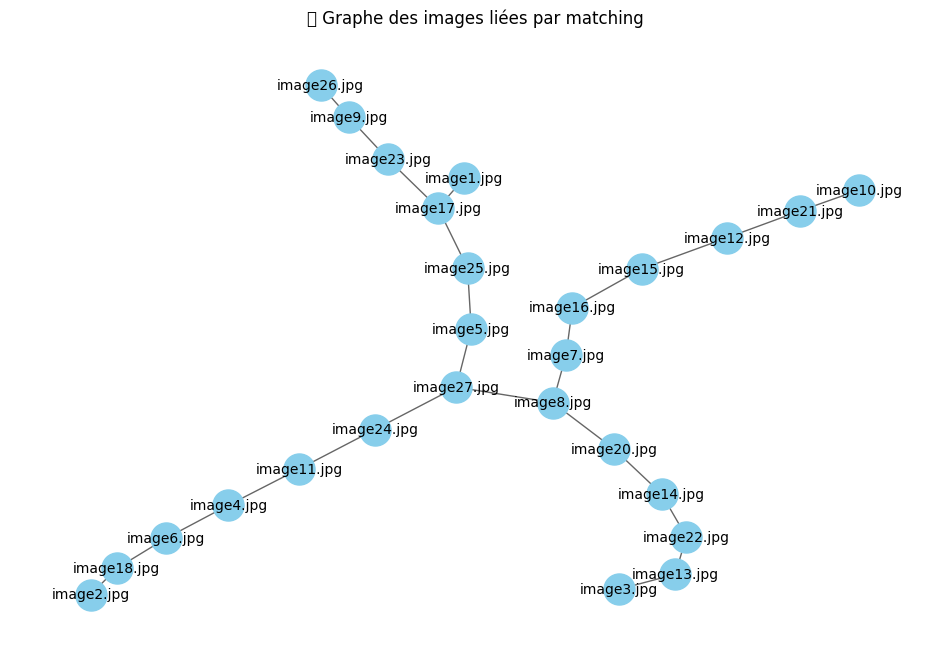

In [43]:
# Conversion du graphe en arbre binaire
root = image_paths[0]
binary_tree = convert_to_binary_tree(graph, root)

# Visualisation avec la fonction existante
visualize_graph(binary_tree)


In [44]:
def binary_tree_to_list(binary_tree, root):
    result = []

    def dfs(node):
        if node is None:
            return
        result.append(node)
        children = binary_tree.get(node, [])
        left = children[0] if len(children) > 0 else None
        right = children[1] if len(children) > 1 else None
        dfs(left)
        dfs(right)

    dfs(root)
    return result


In [45]:
ordered_list = binary_tree_to_list(binary_tree, root)
print("Liste ordonnée du graphe binaire :", ordered_list)


Liste ordonnée du graphe binaire : ['/home/jourdelune/Images/colmap/input/image1.jpg', '/home/jourdelune/Images/colmap/input/image17.jpg', '/home/jourdelune/Images/colmap/input/image23.jpg', '/home/jourdelune/Images/colmap/input/image9.jpg', '/home/jourdelune/Images/colmap/input/image26.jpg', '/home/jourdelune/Images/colmap/input/image25.jpg', '/home/jourdelune/Images/colmap/input/image5.jpg', '/home/jourdelune/Images/colmap/input/image27.jpg', '/home/jourdelune/Images/colmap/input/image24.jpg', '/home/jourdelune/Images/colmap/input/image11.jpg', '/home/jourdelune/Images/colmap/input/image4.jpg', '/home/jourdelune/Images/colmap/input/image6.jpg', '/home/jourdelune/Images/colmap/input/image18.jpg', '/home/jourdelune/Images/colmap/input/image2.jpg', '/home/jourdelune/Images/colmap/input/image8.jpg', '/home/jourdelune/Images/colmap/input/image20.jpg', '/home/jourdelune/Images/colmap/input/image14.jpg', '/home/jourdelune/Images/colmap/input/image22.jpg', '/home/jourdelune/Images/colmap/inp

In [ ]:
from src.photogrammetry_ai import Processor, VGGTProccessor, LightGlueFeatureMatching


images = os.listdir(image_dir)
images = [os.path.join(image_dir, img) for img in images if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

processor = Processor(
    matcher=LightGlueFeatureMatching(),
    extractor=VGGTProccessor(),
    max_batch_size=4,
)

output = processor.process(images)
output.export_colmap("/home/jourdelune/Images/colmap/output")
output.numpy_results()